<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/CINN_for_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.transforms.functional import to_tensor


from scipy.stats import special_ortho_group
from sklearn.datasets import make_moons, load_digits
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import math

### Dataset for the CINN:

In [ ]:
# Function to randomly colorize MNIST dataset with a single color channel
# def random_colorize_rgb_mnist(X):
#     colored_X = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.uint8)

#     for i in range(X.shape[0]):
#         img = X[i]

#         # Generate random color channel index (0 for red, 1 for green, 2 for blue)
#         color_channel_index = np.random.randint(0, 3)

#         # Set the color based on the selected color channel
#         color = [0, 0, 0]
#         color[color_channel_index] = 255

#         # Colorize the digits while keeping the background unchanged
#         colored_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#         colored_img[img > 0] = color
#         colored_X[i] = colored_img

#     return colored_X

In [ ]:
### Load MNIST training dataset
# train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
# uncolored_X_train = train_dataset.data.numpy()
# uncolored_y_train = train_dataset.targets.numpy()

# ### Load MNIST test dataset
# test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
# uncolored_X_test = test_dataset.data.numpy()
# uncolored_y_test = test_dataset.targets.numpy()


# colored_rgb_X_train = random_colorize_rgb_mnist(uncolored_X_train)
# colored_rgb_X_test = random_colorize_rgb_mnist(uncolored_X_test)

# ### labels for the dataset
# # Create labels for uncolored datasets
# uncolored_labels_train = np.zeros(len(uncolored_X_train))
# uncolored_labels_test = np.zeros(len(uncolored_X_test))

# # Create labels for colored datasets
# colored_labels_train = np.ones(len(colored_rgb_X_train))
# colored_labels_test = np.ones(len(colored_rgb_X_test))

In [ ]:
# Reshape uncolored images to (60000, 28, 28, 1)
# uncolored_X_train_resized = uncolored_X_train.reshape(-1, 28, 28, 1)
# uncolored_X_test_resized = uncolored_X_test.reshape(-1, 28, 28, 1)

# # Expand single channel to three channels
# uncolored_X_train_expanded = np.repeat(uncolored_X_train_resized, 3, axis=-1)
# uncolored_X_test_expanded = np.repeat(uncolored_X_test_resized, 3, axis=-1)

In [ ]:
# Normalize the datasets
# # Convert the datasets to float32 before normalization
# uncolored_X_train_expanded = uncolored_X_train_expanded.astype(np.float32)
# uncolored_X_test_expanded = uncolored_X_test_expanded.astype(np.float32)
# colored_rgb_X_train = colored_rgb_X_train.astype(np.float32)
# colored_rgb_X_test = colored_rgb_X_test.astype(np.float32)

# # # Normalize the datasets
# uncolored_X_train_expanded=uncolored_X_train_expanded/255.0
# uncolored_X_test_expanded = uncolored_X_test_expanded/255.0
# colored_rgb_X_train= colored_rgb_X_train/255.0
# colored_rgb_X_test=colored_rgb_X_test/255.0

In [ ]:
# mixed_X_train = np.concatenate((uncolored_X_train_expanded[:len(uncolored_X_train_expanded)],
#                                 colored_rgb_X_train), axis=0)

# mixed_X_test = np.concatenate((uncolored_X_test_expanded[:len(uncolored_X_test_expanded)],
#                                 colored_rgb_X_test), axis=0)

# np.shape(mixed_X_train), np.shape(mixed_X_test)

In [ ]:
# mixed_X_train_tensor = torch.tensor(mixed_X_train)
# mixed_X_test_tensor = torch.tensor(mixed_X_test)
# # Permute the mixed_X_train and mixed_X_test tensors
# mixed_X_train_tensor = mixed_X_train_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension
# mixed_X_test_tensor = mixed_X_test_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension


In [ ]:
# torch.save(mixed_X_train_tensor, "images_train_set.pt")
# torch.save(mixed_X_test_tensor, "images_test_set.pt" )

### Let's now load the saved AE model and begin creating the dataset for the CINN training:

In [ ]:
class Autoencoder_simpler(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(Autoencoder_simpler, self).__init__()

        self.dropout_prob = dropout_prob

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(24 * 7 * 7, 24)  # 64*6 ---> 20

        # Dropout layers
        self.dropout = nn.Dropout(p=self.dropout_prob)  # Add dropout layer

        # Decoder layers
        self.decoder_linear = nn.Linear(24, 24* 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(24, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
    # Encoder
        x = self.encoder_conv1(x)
        #print("After encoder_conv1:", x.shape)
        x = torch.relu(x)
        #print("After relu:", x.shape)
        x = self.dropout(x)  # Apply dropout
        #print("After dropout:", x.shape)
        x = self.encoder_conv2(x)
        #print("After encoder_conv2:", x.shape)
        x = torch.relu(x)
        #print("After relu:", x.shape)
        x = self.dropout(x)  # Apply dropout
        #print("After dropout:", x.shape)
        x = x.reshape(-1, 24 * 7 * 7)  # Use .reshape() instead of .view()
        #print("After reshaping:", x.shape)
        x = self.encoder_linear(x)
        #print("After encoder_linear:", x.shape)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 24, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        x = torch.clamp(x, 0, 1) # Clamp output
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Define the path to the pretrained model
checkpoint_path = "/content/autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth"

# Load the pretrained model
pretrained_model_list = torch.load(checkpoint_path,map_location=torch.device('cpu'))

ae_model=Autoencoder_simpler(dropout_prob=0.01)

ae_model.load_state_dict(pretrained_model_list)

<All keys matched successfully>

In [ ]:
# ae_model.eval()
# images_test_set=ae_model.encoder(mixed_X_test_tensor)
# images_train_set= ae_model.encoder(mixed_X_train_tensor)

In [ ]:
# images_test_set.size(), images_train_set.size()

In [ ]:
# torch.save(images_train_set, "encoded_images_train_set.pt")

In [ ]:
# torch.save(images_test_set, "encoded_images_test_set.pt")

### Let's load the dataset here:

In [ ]:
encoded_image_train_set=torch.load("/content/encoded_images_train_set.pt")
encoded_image_train_set=encoded_image_train_set[30000:90000,:]
encoded_image_test_set= torch.load("/content/encoded_images_test_set.pt")

In [ ]:
encoded_image_train_set.size(), encoded_image_test_set.size()

(torch.Size([60000, 24]), torch.Size([20000, 24]))

In [ ]:
### 0 for uncolored and 1 for colored
len_train=encoded_image_train_set.size()[0]
len_test=encoded_image_test_set.size()[0]

labels_train= torch.cat((torch.zeros(len_train // 2),torch.ones(len_train // 2)))
labels_test = torch.cat((torch.zeros(len_test // 2),torch.ones(len_test // 2)))

In [ ]:
encoded_image_train_set.size(), labels_train.size(), encoded_image_test_set.size(), labels_test.size()

(torch.Size([60000, 24]),
 torch.Size([60000]),
 torch.Size([20000, 24]),
 torch.Size([20000]))

shuffled data

In [ ]:
# # Define the random seed for reproducibility
# torch.manual_seed(42)

# # Generate shuffled indices
# shuffled_indices_train = torch.randperm(encoded_image_train_set.size(0))
# shuffled_indices_test = torch.randperm(encoded_image_test_set.size(0))

# # Shuffle the data and labels using the shuffled indices
# shuffled_encoded_image_train_set = encoded_image_train_set[shuffled_indices_train]
# shuffled_labels_train = labels_train[shuffled_indices_train]

# shuffled_encoded_image_test_set = encoded_image_test_set[shuffled_indices_test]
# shuffled_labels_test = labels_test[shuffled_indices_test]

In [ ]:
# shuffled_indices_train[:6], shuffled_labels_train[:6]

### Creating the dataloader

In [ ]:
# import torch
# from torch.utils.data import Dataset, Dataloader

# # Set random seed for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)

# # Define custom dataset class
# class CustomDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.color_labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.color_labels[idx]

# # Create custom datasets for train and test
# train_dataset = CustomDataset(encoded_image_train_set, labels_train)
# test_dataset = CustomDataset(encoded_image_test_set, labels_test)

# batch_size=64

# # Create data loaders with shuffling and fixed random seed
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Assuming you have a CustomDataset class defined
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.color_labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.color_labels[idx]

# Assuming you have the train_dataset
train_dataset = CustomDataset(encoded_image_train_set, labels_train)
test_dataset = CustomDataset(encoded_image_test_set, labels_test)

# Calculate the number of samples for training and validation
total_samples = len(train_dataset)
train_size = int(0.9 * total_samples)
val_size = total_samples - train_size

# Split the train_dataset into train and val datasets with a fixed random seed
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))

# Define batch size
batch_size = 32

# Create data loaders for train, val, and test sets with shuffling and fixed random seed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          worker_init_fn=np.random.seed)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Get the first batch of the train_loader
first_batch = next(iter(train_loader))

# Extract data and labels from the first batch
data, labels = first_batch

# Print the size of the first batch
print("Data Shape:", data.shape)
print("Labels:", labels)

Data Shape: torch.Size([32, 24])
Labels: tensor([1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.])


In [ ]:
# for data in train_loader:
#   print(type(data))
#   print(data)
#   print(data[0].shape)
#   break

### CINN code:

In [ ]:
def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model

def ortogonal_matrix(dim):
    """
    A = torch.normal(mean=torch.zeros((dim,dim)), std=torch.ones((dim,dim)))
    Q, _ = torch.linalg.qr(A)
    if dim == 2:
        Q[1,1] = -Q[0,0]
        Q[0,1] = -Q[1,0]
        print(torch.linalg.det(Q))
    return Q
    """
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)



In [ ]:
class conditional_coupling_block(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[...,:self.split2], params[...,self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1,x2], -1), ljd

        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1,x2], -1)



In [ ]:
# class conditional_realNVP(nn.Module):
#     def __init__(self, input_size, hidden_size, n_blocks, condition_size):
#         super().__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.n_blocks = n_blocks
#         self.condition_size = condition_size

#         self.coupling_blocks = nn.ModuleList([conditional_coupling_block(input_size, hidden_size, self.condition_size) for _ in range(n_blocks)])
#         self.orthogonal_matrices = [ortogonal_matrix(input_size) for _ in range(n_blocks-1)]

class conditional_realNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size
        self.device = device

        # Move conditional_coupling_blocks to specified device
        self.coupling_blocks = nn.ModuleList([
            conditional_coupling_block(input_size, hidden_size, self.condition_size).to(device)
            for _ in range(n_blocks)
        ])

        self.orthogonal_matrices = [ortogonal_matrix(input_size).to(device) for _ in range(n_blocks-1)]


    def forward(self, x, cond, rev=False):
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size)
        ljd = torch.zeros((x.shape[0])).to(device)
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x, cond):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size)
        for l in range(self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c*torch.ones(num_samples)))
        else:
            z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond*torch.ones(num_samples)))
        return torch.cat(samples, 0)


In [ ]:
def mmd_inverse_multi_quadratic(x, y, bandwidths=None):
    batch_size = x.size()[0]

    # compute the kernel matrices for each combination of x, y
    # (cleverly using broadcasting to do this efficiently)
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    # compute the sum of kernels at different bandwidths
    K, L, P = 0, 0, 0
    if bandwidths is None:
        bandwidths = [0.4, 0.8, 1.6]
    for sigma in bandwidths:
        s = 1.0 / sigma**2
        K += 1.0 / (1.0 + s * (rx.t() + rx - 2.0*xx))
        L += 1.0 / (1.0 + s * (ry.t() + ry - 2.0*yy))
        P += 1.0 / (1.0 + s * (rx.t() + ry - 2.0*xy))

    beta = 1./(batch_size*(batch_size-1)*len(bandwidths))
    gamma = 2./(batch_size**2 * len(bandwidths))

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [ ]:
# def train_cinn_moons(model, batchsize=1000, epochs=1000, lr=0.001):
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         x_data, y_data = make_moons(n_samples=batchsize, shuffle=True, noise=0.1, random_state=42)
#         x_data, y_data = torch.Tensor(x_data), torch.Tensor(y_data)
#         z, ljd = model(x_data, y_data)
#         loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
#         loss.backward()
#         optimizer.step()
#         if (epoch+1) % (epochs//3) == 0:
#             print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


In [ ]:
# train and evaluate function
def train_and_evaluate_cinn(model, train_loader, val_loader, device,
                       num_epochs=10, learning_rate=1e-3, weight_decay=0.001,
                       step_size_scheduler=5,gamma_scheduler=0.5,
                       print_epoch=10, ):


    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=step_size_scheduler,
                                          gamma= gamma_scheduler)  # Learning rate scheduler

    model.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for data in train_loader:
            x_data, y_data = data[0], data[1] # extract the data
            x_data, y_data = x_data.to(device), y_data.to(device)

            batch_size = x_data.size(0)  # Get actual batch size


            optimizer.zero_grad()
            z, ljd = model(x_data, y_data)

            loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batch_size
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                x_data, y_data = data[0], data[1] # extract the data
                x_data, y_data = x_data.to(device), y_data.to(device)
                batch_size = x_data.size(0)  # Get actual batch size

                z, ljd = model(x_data, y_data)
                loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batch_size

                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses


In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# checking the shape of the make_moons dataset
# x_data, y_data = make_moons(n_samples=5, shuffle=True, noise=0.1, random_state=42)
# x_data, y_data = torch.Tensor(x_data), torch.Tensor(y_data)
# y_data.size(), x_data.size()# y data is the sample :)

The only major change we need to do in this code:

~1. Replace x_data (data from domain 1) and y_data (dataset: condition vectors) with our data and condition respectively.~

2. Some changes in the `_forward` function in line number 18 in `conditional_real_nvp` class.

In [ ]:
# cINN_moons = conditional_realNVP(2, 64, 10, 2)
# train_cinn_moons(cINN_moons, epochs=100)



In [ ]:
# moons_samples = cINN_moons.sample(1000)
# true_moons_data, _ = make_moons(n_samples=2000, shuffle=True, noise=0.1, random_state=42)
# true_moons_data = torch.Tensor(true_moons_data)
# plt.scatter(moons_samples[:,0].detach().numpy(), moons_samples[:,1].detach().numpy())
# mmd_score = mmd_inverse_multi_quadratic(moons_samples, true_moons_data)
# plt.title(f"Moons Samples from cINN (hidden size 64, 10 layers, 100 epochs), MMD={mmd_score:.6f}")
# plt.show()

Let's try to train CINN on our dataset so that we can proceed with the task of style transfer:

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
# let's instantiate the model
model_cinn_style_transfer= conditional_realNVP(input_size=24, hidden_size=20,n_blocks=4
                                               , condition_size=2)
# model_cinn_style_transfer.to(device)
model_cinn_style_transfer

conditional_realNVP(
  (coupling_blocks): ModuleList(
    (0-3): 4 x conditional_coupling_block(
      (subnet): Sequential(
        (0): Linear(in_features=14, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): ReLU()
        (4): Linear(in_features=20, out_features=24, bias=True)
      )
    )
  )
)

In [ ]:
args_dict = {
    'model': model_cinn_style_transfer,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'num_epochs': 10,
    'learning_rate': 1e-3,
    'weight_decay': 0.001,
    'step_size_scheduler': 100,
    'gamma_scheduler': 0.5,
    'print_epoch': 1,
    'device': device
}


In [ ]:
# let's train and evaluate
train_loss, val_loss = train_and_evaluate_cinn(**args_dict)

Epochs:  10%|█         | 1/10 [01:13<11:00, 73.43s/it]


Epoch [1/10], Train Loss: 5.170878994, Val Loss: 2.553683431


Epochs:  20%|██        | 2/10 [02:27<09:51, 73.88s/it]


Epoch [2/10], Train Loss: 1.919963776, Val Loss: 1.386568827


Epochs:  30%|███       | 3/10 [03:41<08:37, 73.87s/it]


Epoch [3/10], Train Loss: 1.073152369, Val Loss: 0.804113093


Epochs:  40%|████      | 4/10 [04:54<07:22, 73.67s/it]


Epoch [4/10], Train Loss: 0.618070574, Val Loss: 0.681711773


Epochs:  50%|█████     | 5/10 [06:13<06:18, 75.62s/it]


Epoch [5/10], Train Loss: 0.294919925, Val Loss: 0.207903546


Epochs:  60%|██████    | 6/10 [07:35<05:10, 77.57s/it]


Epoch [6/10], Train Loss: 0.062222273, Val Loss: -0.014849510


Epochs:  70%|███████   | 7/10 [08:53<03:52, 77.66s/it]


Epoch [7/10], Train Loss: -0.120821415, Val Loss: -0.185287882


Epochs:  80%|████████  | 8/10 [10:07<02:33, 76.73s/it]


Epoch [8/10], Train Loss: -0.276890784, Val Loss: -0.259370850


Epochs:  90%|█████████ | 9/10 [11:39<01:21, 81.36s/it]


Epoch [9/10], Train Loss: -0.397113774, Val Loss: -0.411923481


Epochs: 100%|██████████| 10/10 [12:54<00:00, 77.45s/it]


Epoch [10/10], Train Loss: -0.507025045, Val Loss: -0.461338713


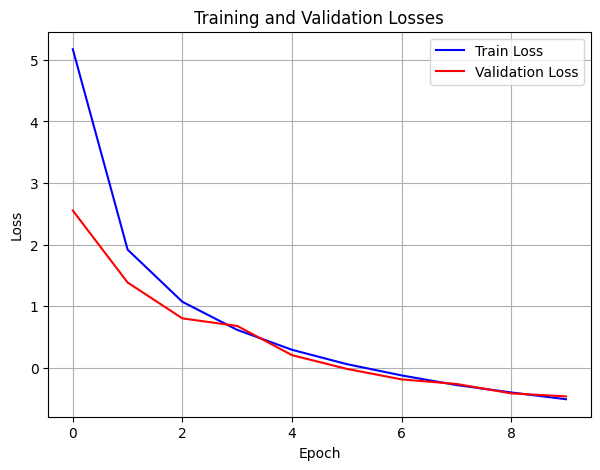

In [ ]:
plot_losses(train_loss, val_loss)

### let's attempt style transfer

In [ ]:
i=69
x_uncolored, y_label=encoded_image_test_set[i,:], labels_test[i]
x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)

y_label

tensor(0., device='cuda:0')

In [ ]:
# get the residual
model_cinn_style_transfer.eval()
z,_ = model_cinn_style_transfer(x_uncolored, y_label)

In [ ]:
z.shape, y_label.shape

(torch.Size([24]), torch.Size([]))

In [ ]:
y_label_colored= torch.ones(1).to(device)
y_label_colored[0], y_label_colored[0].shape

(tensor(1., device='cuda:0'), torch.Size([]))

In [ ]:
# transfer the style
model_cinn_style_transfer.eval()
x_transfered = model_cinn_style_transfer._inverse(z,y_label_colored[0])

In [ ]:
# # Define the path to the pretrained model
# checkpoint_path = "/content/autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth"

# # Load the pretrained model
# pretrained_model_list = torch.load(checkpoint_path,map_location=torch.device('cpu'))

# ae_model=Autoencoder_simpler(dropout_prob=0.01)

# ae_model.load_state_dict(pretrained_model_list)

ae_model.to(device)

Autoencoder_simpler(
  (encoder_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_linear): Linear(in_features=1176, out_features=24, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (decoder_linear): Linear(in_features=24, out_features=1176, bias=True)
  (decoder_conv1): ConvTranspose2d(24, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [ ]:
### let's send x through the decoder
ae_model.eval()

decoded_x_style_trans= ae_model.decoder(x_transfered)

decoded_original= ae_model.decoder(x_uncolored)

In [ ]:
decoded_x_style_trans.shape, decoded_original.shape

(torch.Size([1, 3, 28, 28]), torch.Size([1, 3, 28, 28]))

In [ ]:
def plot_images(image1, image2):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(np.transpose(image1.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[0].set_title('True Image')
    axes[0].axis('off')

    axes[1].imshow(np.transpose(image2.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[1].set_title('Style Transferred')
    axes[1].axis('off')

    plt.show()

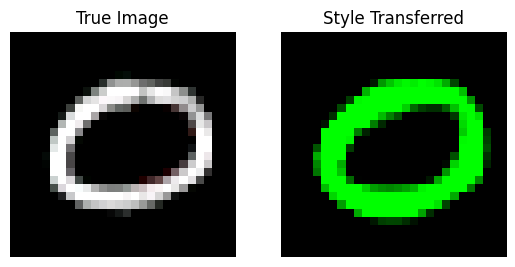

In [ ]:
plot_images(decoded_original, decoded_x_style_trans)

Tasks for me:

1. Clean the notebook.
2. Run the code with more number of dataset and more number of coupling blocks.
3. add functions to plot the results.